# Denoising Autoencoders And Where To Find Them

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

# Import stuff

In [1]:
import sys
sys.path.append("..")
import grading

In [2]:
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
from lfw_dataset import load_lfw_dataset
%matplotlib inline
import matplotlib.pyplot as plt
import download_utils
import keras_utils
import numpy as np

Using TensorFlow backend.


In [3]:
# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
def reset_tf_session():
    K.clear_session()
    tf.reset_default_graph()
    s = K.get_session()
    return s

# Load dataset
Dataset was downloaded for you. Relevant links (just in case):
- http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
- http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
- http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [4]:
# we downloaded them for you, just link them here
! ln -s $(realpath ../readonly/week4/*) .

ln: failed to create symbolic link ‘./lfw-deepfunneled.tgz’: File exists
ln: failed to create symbolic link ‘./lfw.tgz’: File exists
ln: failed to create symbolic link ‘./lfw_attributes.txt’: File exists


In [5]:
# load images
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)
IMG_SHAPE = X.shape[1:]

# center images
X = X.astype('float32') / 255.0 - 0.5

# split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [37]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

X shape: (13143, 32, 32, 3)
attr shape: (13143, 73)


3360

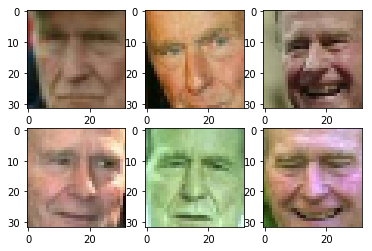

In [7]:
plt.title('sample images')

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(X[i])

print("X shape:", X.shape)
print("attr shape:", attr.shape)

# try to free memory
del X
import gc
gc.collect()

### Autoencoder architecture

Let's design autoencoder as two sequential keras models: the encoder and decoder respectively.

We will then use symbolic API to apply and train those models.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [8]:
def build_pca_autoencoder(img_shape,code_size=32):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size))           #actual encoder

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder,decoder

Meld them together into one model

In [9]:

s = reset_tf_session()

encoder, decoder = build_pca_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

In [35]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

In [11]:
autoencoder.fit(x=X_train, y=X_train, epochs=15,
                validation_data=[X_test, X_test],
                callbacks=[keras_utils.TqdmProgressCallback()],
                verbose=0)


Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15



PCA MSE: 0.00660577879638


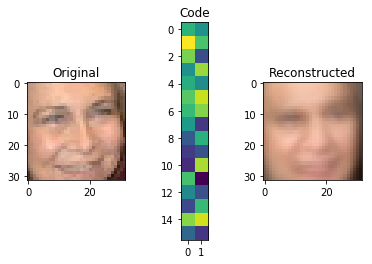

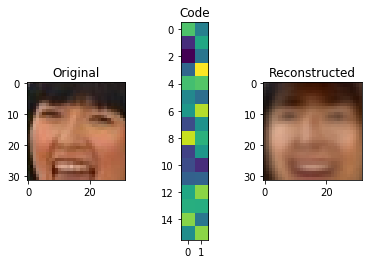

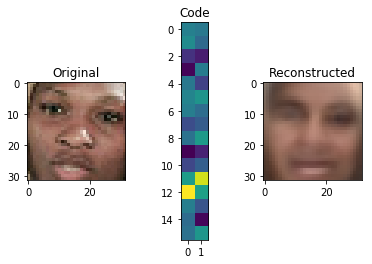

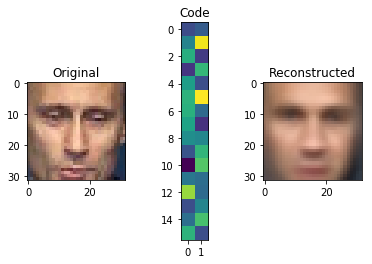

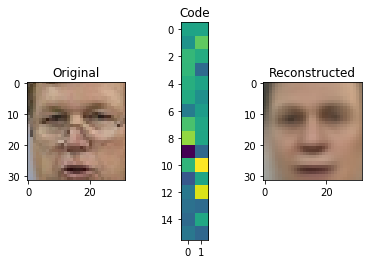

In [12]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("PCA MSE:", score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [6]:
# Let's play around with transpose convolution on examples first
def test_conv2d_transpose(img_size, filter_size):
    print("Transpose convolution test for img_size={}, filter_size={}:".format(img_size, filter_size))
    
    x = (np.arange(img_size ** 2, dtype=np.float32) + 1).reshape((1, img_size, img_size, 1))
    f = (np.ones(filter_size ** 2, dtype=np.float32)).reshape((filter_size, filter_size, 1, 1))

    conv = tf.nn.conv2d_transpose(x, f, 
                                  output_shape=(1, img_size * 2, img_size * 2, 1), 
                                  strides=[1, 2, 2, 1], 
                                  padding='SAME')

    with tf.Session() as session:
        result = session.run(conv)
        print("input:")
        print(x[0, :, :, 0])
        print("filter:")
        print(f[:, :, 0, 0])
        print("output:")
        print(result[0, :, :, 0])
        
test_conv2d_transpose(img_size=2, filter_size=2)
test_conv2d_transpose(img_size=2, filter_size=3)
test_conv2d_transpose(img_size=4, filter_size=2)
test_conv2d_transpose(img_size=4, filter_size=3)

Transpose convolution test for img_size=2, filter_size=2:
input:
[[ 1.  2.]
 [ 3.  4.]]
filter:
[[ 1.  1.]
 [ 1.  1.]]
output:
[[ 1.  1.  2.  2.]
 [ 1.  1.  2.  2.]
 [ 3.  3.  4.  4.]
 [ 3.  3.  4.  4.]]
Transpose convolution test for img_size=2, filter_size=3:
input:
[[ 1.  2.]
 [ 3.  4.]]
filter:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
output:
[[  1.   1.   3.   2.]
 [  1.   1.   3.   2.]
 [  4.   4.  10.   6.]
 [  3.   3.   7.   4.]]
Transpose convolution test for img_size=4, filter_size=2:
input:
[[  1.   2.   3.   4.]
 [  5.   6.   7.   8.]
 [  9.  10.  11.  12.]
 [ 13.  14.  15.  16.]]
filter:
[[ 1.  1.]
 [ 1.  1.]]
output:
[[  1.   1.   2.   2.   3.   3.   4.   4.]
 [  1.   1.   2.   2.   3.   3.   4.   4.]
 [  5.   5.   6.   6.   7.   7.   8.   8.]
 [  5.   5.   6.   6.   7.   7.   8.   8.]
 [  9.   9.  10.  10.  11.  11.  12.  12.]
 [  9.   9.  10.  10.  11.  11.  12.  12.]
 [ 13.  13.  14.  14.  15.  15.  16.  16.]
 [ 13.  13.  14.  14.  15.  15.  16.  16.]]
Transpose c

In [29]:
from keras.layers import Conv2D, Deconv2D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D

def build_deep_autoencoder(img_shape,code_size=32):
    """PCA's deeper brother. See instructions above"""
    H,W,C = img_shape
    
    # Encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    
    encoder.add(Conv2D(filters=code_size*8, kernel_size=2, padding='same', activation='relu'))
    encoder.add(Conv2D(filters=code_size*4, kernel_size=2, padding='same', activation='relu'))
    encoder.add(Conv2D(filters=code_size, kernel_size=2, padding='same', activation='tanh'))
    encoder.add(Conv2D(filters=code_size, kernel_size=2, padding='same', activation='tanh'))
    encoder.add(MaxPooling2D())
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))
    
    # Decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size, )))
    
    decoder.add(L.Dense(int(H/2*W/2*code_size)))
    decoder.add(L.Reshape( (int(H/2), int(W/2), int(code_size))) )
    decoder.add(Deconv2D(filters=code_size, kernel_size=2, padding='same', activation='tanh'))
    decoder.add(Deconv2D(filters=code_size, kernel_size=2, padding='same', activation='tanh'))
    decoder.add(Deconv2D(filters=code_size*4, kernel_size=2, padding='same', activation='relu'))
    decoder.add(Deconv2D(filters=code_size*8, kernel_size=2, padding='same', activation='relu'))
    decoder.add(UpSampling2D())
    decoder.add(Conv2D(filters=C, kernel_size=3, padding='same', activation='tanh'))


    return encoder,decoder


In [30]:
# Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512]:
    s = reset_tf_session()
    encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==IMG_SHAPE,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")
s = reset_tf_session()

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
All tests passed!


In [31]:
# Look at encoder and decoder shapes.
# Total number of trainable parameters of encoder and decoder should be close.
s = reset_tf_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       3328      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        16416     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
__________

__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

Training may take some 20 minutes.

In [32]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='weights.best.deepEncoder.hdf5', 
                               verbose=1, save_best_only=True)

s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

# we will save model checkpoints here to continue training in case of kernel death
model_filename = 'autoencoder.{0}.hdf5'

#### uncomment below to continue training from model checkpoint
#### every time epoch counter starts at 0, so you need to track epochs manually
# from keras.models import load_model
# s = reset_tf_session()
# autoencoder = load_model(model_filename.format(0))  # continue after epoch 0+1
# encoder = autoencoder.layers[1]
# decoder = autoencoder.layers[2]

autoencoder.fit(x=X_train, y=X_train, epochs=25,
                validation_data=[X_test, X_test],
                callbacks=[keras_utils.TqdmProgressCallback(),
                           checkpointer],
                verbose=0)

Epoch 1/25
11828/|/loss: 0.013: 100%|| 11828/11828 [21:11<00:00, 10.38it/s]
Epoch 00000: val_loss improved from inf to 0.00768, saving model to weights.best.deepEncoder.hdf5
Epoch 2/25
11828/|/loss: 0.007: 100%|| 11828/11828 [17:31<00:00, 11.60it/s]
Epoch 00001: val_loss improved from 0.00768 to 0.00686, saving model to weights.best.deepEncoder.hdf5
Epoch 3/25

Epoch 00002: val_loss improved from 0.00686 to 0.00655, saving model to weights.best.deepEncoder.hdf5
Epoch 4/25
11828/|/loss: 0.006: 100%|| 11828/11828 [17:51<00:00, 11.48it/s]
Epoch 00003: val_loss improved from 0.00655 to 0.00655, saving model to weights.best.deepEncoder.hdf5
Epoch 5/25
11828/|/loss: 0.006: 100%|| 11828/11828 [17:21<00:00, 11.61it/s]
Epoch 00004: val_loss improved from 0.00655 to 0.00622, saving model to weights.best.deepEncoder.hdf5
Epoch 6/25
11828/|/loss: 0.006: 100%|| 11828/11828 [18:31<00:00, 10.66it/s]
Epoch 00005: val_loss improved from 0.00622 to 0.00611, saving model to weights.best.deepEncoder.hdf5


In [33]:
autoencoder.load_weights('weights.best.deepEncoder.hdf5')

Convolutional autoencoder MSE: 0.00546449952575


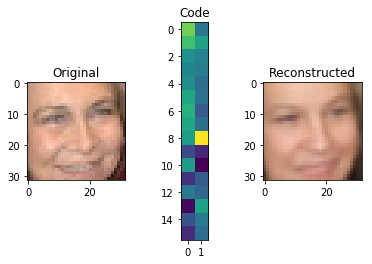

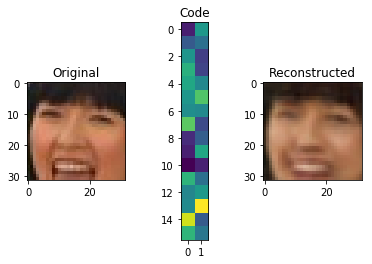

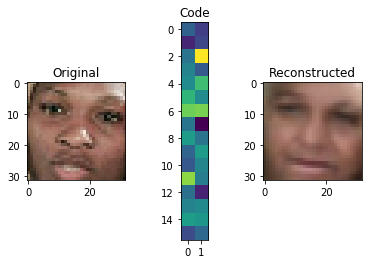

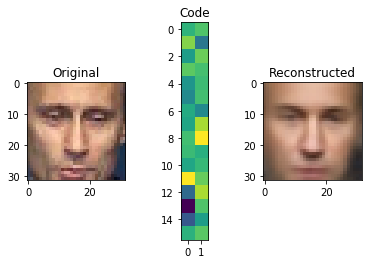

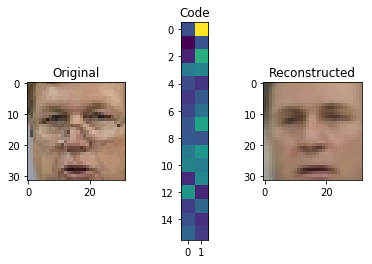

In [38]:
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [39]:
# save trained weights
encoder.save_weights("encoder.h5")
decoder.save_weights("decoder.h5")

In [40]:
# restore trained weights
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

print(autoencoder.evaluate(X_test, X_test, verbose=0))
print(reconstruction_mse)

0.00546449952575
0.00546449952575


# Submit to Coursera

In [41]:
from submit import submit_autoencoder
submission = build_deep_autoencoder(IMG_SHAPE, code_size=71)

# token expires every 30 min
COURSERA_EMAIL = 'dangledangkhoa@gmail.com'
COURSERA_TOKEN = 'D1R8APxkzseTIOeF'

submit_autoencoder(submission, reconstruction_mse, COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 32 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [ ]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    
    # <your code here>
    noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
    return X + noise
    

In [ ]:
#noise tests
theoretical_std = (X[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X[:100],sigma=0.5).mean() - X[:100].mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

In [ ]:
plt.subplot(1,4,1)
plt.imshow(X[0])
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.5)[0])

In [ ]:
encoder,decoder = build_deep_autoencoder(img_shape,code_size=512)
assert encoder.output_shape[1:]==(512,), "encoder must output a code of required size"

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

In [ ]:
for i in range(50):
    print("Epoch %i/50, Generating corrupted samples..."%i)
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    
    autoencoder.fit(x=X_train_noise,y=X_train,epochs=1,
                    validation_data=[X_test_noise,X_test])

__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

In [ ]:
denoising_mse = autoencoder.evaluate(apply_gaussian_noise(X_test),X_test,verbose=0)
print("Final MSE:", denoising_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [ ]:
encoder.save("./encoder.h5")
decoder.save("./decoder.h5")

### Submit to Coursera

In [ ]:
EMAIL = ''
TOKEN = ''

from submit import submit_autoencoder
submission = build_deep_autoencoder(img_shape,code_size=71)
submit_autoencoder(submission, reconstruction_mse, EMAIL, TOKEN)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [ ]:
images = X_train
codes = <encode all images>
assert len(codes) == len(images)

In [ ]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [ ]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
#smiles
show_similar(X_test[2])

In [ ]:
#ethnicity
show_similar(X_test[500])

In [ ]:
#glasses
show_similar(X_test[66])

## Bonus: cheap image morphing


In [ ]:

for _ in range(5):
    image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]

    code1, code2 = encoder.predict(np.stack([image1,image2]))

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = decoder.predict(output_code[None])[0]

        plt.subplot(1,7,i+1)
        plt.imshow(output_image)
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.

If you want to generate images from scratch, however, we recommend you our honor track seminar about generative adversarial networks.